In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, hour, dayofweek, date_format, \
                                  when, mean, count, sum as spark_sum, isnan
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Creating a spark session
spark = SparkSession.builder \
    .appName("NYC_Taxi_Assignment_3_2025") \
    .getOrCreate()

25/11/18 11:17:53 WARN Utils: Your hostname, Nickys-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.101.198.30 instead (on interface en0)
25/11/18 11:17:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/18 11:17:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load Parquet Data
input_path = "yellow_tripdata_202501.parquet"

df = spark.read.parquet(input_path)
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



In [4]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [5]:
print(f"The DataFrame has {df.count()} rows.")

The DataFrame has 3475226 rows.


In [6]:
# Basic Null Checks for all columns
float_types = ['double', 'float']
schema = dict(df.dtypes)
null_exprs = [
	F.count(
		when(
			col(c).isNull() | (isnan(col(c)) if schema[c] in float_types else F.lit(False)),
			c
		)
	).alias(f"{c}_missing")
	for c in df.columns
]
null_counts = df.select(null_exprs)
null_counts.show()

+----------------+----------------------------+-----------------------------+-----------------------+---------------------+------------------+--------------------------+--------------------+--------------------+--------------------+-------------------+-------------+---------------+------------------+--------------------+-----------------------------+--------------------+----------------------------+-------------------+--------------------------+
|VendorID_missing|tpep_pickup_datetime_missing|tpep_dropoff_datetime_missing|passenger_count_missing|trip_distance_missing|RatecodeID_missing|store_and_fwd_flag_missing|PULocationID_missing|DOLocationID_missing|payment_type_missing|fare_amount_missing|extra_missing|mta_tax_missing|tip_amount_missing|tolls_amount_missing|improvement_surcharge_missing|total_amount_missing|congestion_surcharge_missing|Airport_fee_missing|cbd_congestion_fee_missing|
+----------------+----------------------------+-----------------------------+-----------------------

In [7]:
key_cols = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "trip_distance",
    "fare_amount",
    "passenger_count"
]

missing_data = df.select([
    count(when(col(c).isNull(), c)).alias(f"{c}_missing")
    for c in key_cols
])
missing_data.show()

+----------------------------+-----------------------------+---------------------+-------------------+-----------------------+
|tpep_pickup_datetime_missing|tpep_dropoff_datetime_missing|trip_distance_missing|fare_amount_missing|passenger_count_missing|
+----------------------------+-----------------------------+---------------------+-------------------+-----------------------+
|                           0|                            0|                    0|                  0|                 540149|
+----------------------------+-----------------------------+---------------------+-------------------+-----------------------+



In [8]:
print(f"passenger_count_missing column has {(missing_data.collect()[0]['passenger_count_missing'] / df.count()) * 100:.2f}% missing values.")

passenger_count_missing column has 15.54% missing values.


In [9]:
df = (
    df
    .withColumnRenamed("tpep_pickup_datetime", "pickup_datetime")
    .withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime")
)

In [10]:
# Encode the payment types to labels
df = df.withColumn(
    "payment_type_label",
    when(col("payment_type") == 1, "Credit card")
    .when(col("payment_type") == 2, "Cash")
    .when(col("payment_type") == 3, "No charge")
    .when(col("payment_type") == 4, "Dispute")
    .when(col("payment_type") == 5, "Unknown")
    .when(col("payment_type") == 6, "Voided trip")
    .otherwise("Other")
)
df.select("payment_type", "payment_type_label").distinct().show()

+------------+------------------+
|payment_type|payment_type_label|
+------------+------------------+
|           3|         No charge|
|           5|           Unknown|
|           2|              Cash|
|           4|           Dispute|
|           1|       Credit card|
|           0|             Other|
+------------+------------------+



# Task A: Trip Duration & Speed

In [11]:
# Compute trip duration (minutes) and average speed (mph)
# duration_min = (dropoff - pickup)/60
# avg_mph = trip_distance / duration_hours
df_A = df.withColumn(
    "trip_duration_minutes",
    (unix_timestamp(col("dropoff_datetime")) - unix_timestamp(col("pickup_datetime"))) / 60
).withColumn(
        "average_speed_mph",
        col("trip_distance") / (col("trip_duration_minutes") / 60)
)
df_A.select("pickup_datetime", 
            "dropoff_datetime", 
            "trip_duration_minutes", 
            "trip_distance", 
            "average_speed_mph").show(5)

+-------------------+-------------------+---------------------+-------------+------------------+
|    pickup_datetime|   dropoff_datetime|trip_duration_minutes|trip_distance| average_speed_mph|
+-------------------+-------------------+---------------------+-------------+------------------+
|2025-01-01 00:18:38|2025-01-01 00:26:59|                 8.35|          1.6|11.497005988023954|
|2025-01-01 00:32:40|2025-01-01 00:35:13|                 2.55|          0.5|11.764705882352942|
|2025-01-01 00:44:04|2025-01-01 00:46:01|                 1.95|          0.6| 18.46153846153846|
|2025-01-01 00:14:27|2025-01-01 00:20:01|    5.566666666666666|         0.52| 5.604790419161676|
|2025-01-01 00:21:34|2025-01-01 00:25:06|    3.533333333333333|         0.66|11.207547169811322|
+-------------------+-------------------+---------------------+-------------+------------------+
only showing top 5 rows



In [12]:
# Keep realistic trips only (e.g., avg_mph <= 80 and positive distances/fares)
df_A_filtered = df_A.filter(
    (col("average_speed_mph") <= 80) &
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("passenger_count").between(1, 8)) & col("passenger_count").isNotNull()
)
df_A_filtered.show(5)

+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+---------------------+------------------+
|VendorID|    pickup_datetime|   dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|payment_type_label|trip_duration_minutes| average_speed_mph|
+--------+-------------------+-------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-

In [13]:
# Aggregate by hour of day (from pickup time): average speed, average duration, trip counts.
df_A_filtered = df_A_filtered.withColumn("pickup_hour", hour(col("pickup_datetime")))

taskA_by_hour = (
    df_A_filtered
    .groupBy("pickup_hour")
    .agg(
        count("*").alias("trip_count"),
        mean("trip_duration_minutes").alias("avg_duration_min"),
        mean("average_speed_mph").alias("avg_speed_mph")
    )
    .orderBy("pickup_hour")
)

taskA_by_hour.show(24)

+-----------+----------+------------------+------------------+
|pickup_hour|trip_count|  avg_duration_min|     avg_speed_mph|
+-----------+----------+------------------+------------------+
|          0|     65093|13.988513357811094| 14.72306045610306|
|          1|     43655|12.834537471843607|14.063834919226068|
|          2|     29446|12.629505988362824|13.943143359105708|
|          3|     19138|12.416694534434109|14.913260458948665|
|          4|     12320|14.393705357142887|17.951911969705545|
|          5|     15368|16.867539692868288| 19.35842725428879|
|          6|     34858|15.842419243789145|15.674150760178112|
|          7|     74093|15.298085514151085| 12.72397212774188|
|          8|    105776| 15.26668415645639|10.841754949434614|
|          9|    122139|15.052624332386298|10.737318629889282|
|         10|    133513|15.020036251151584|10.681124797047566|
|         11|    144557|15.408032356325407|10.190039311270256|
|         12|    157010| 15.30652198373779|10.241280316

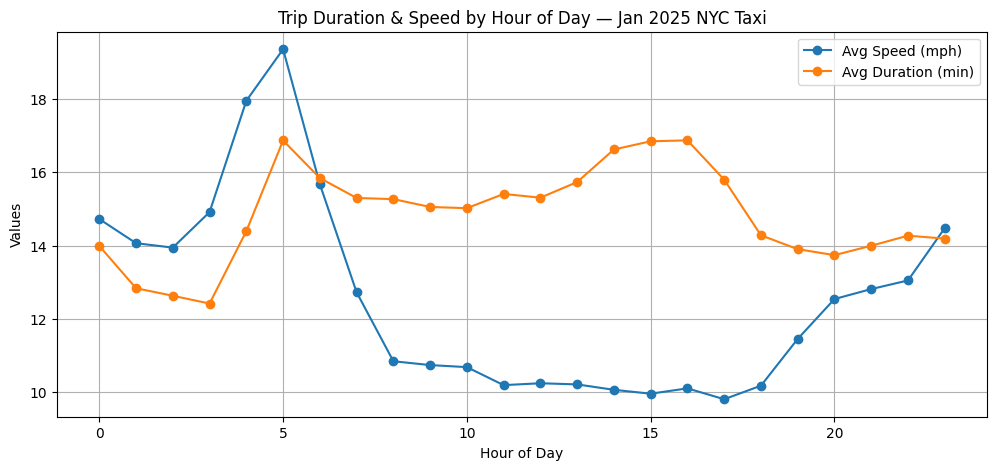

In [14]:
# Convert to pandas for plotting
taskA_pd = taskA_by_hour.toPandas()

plt.figure(figsize=(12,5))
plt.plot(taskA_pd['pickup_hour'], taskA_pd['avg_speed_mph'], marker='o', label='Avg Speed (mph)')
plt.plot(taskA_pd['pickup_hour'], taskA_pd['avg_duration_min'], marker='o', label='Avg Duration (min)')
plt.xlabel("Hour of Day")
plt.ylabel("Values")
plt.title("Trip Duration & Speed by Hour of Day — Jan 2025 NYC Taxi")
plt.grid(True)
plt.legend()
plt.show()

`Insights:`
- Speeds are highest and trips are quickest between midnight and early morning, when the streets are mostly empty and travel is smooth.
- Around 6–10 AM, average speeds drop sharply while trip durations climb, reflecting the morning commute and heavy inbound traffic.
- Late morning through mid-afternoon settles into a more predictable pattern - speeds stabilize around typical city flow, and durations remain fairly consistent.
- A second slowdown emerges in the late afternoon and early evening, marking the evening rush as commuters head home and streets become crowded again.
- After about 8–9 PM, traffic gradually eases, speeds rise, and trip durations shorten.

In [15]:
# Further analyze data by categorizing into time periods
df_peak = df_A_filtered.withColumn(
    "period",
    when((col("pickup_hour") >= 6) & (col("pickup_hour") <= 10), "Morning Peak")
    .when((col("pickup_hour") >= 16) & (col("pickup_hour") <= 19), "Evening Peak")
    .when((col("pickup_hour") >= 0) & (col("pickup_hour") <= 5), "Late Night")
    .otherwise("Off-Peak")
)

period_stats = (
    df_peak.groupBy("period")
    .agg(
        count("*").alias("trip_count"),
        F.round(mean("trip_duration_minutes"), 2).alias("avg_duration_min"),
        F.round(mean("average_speed_mph"), 2).alias("avg_speed_mph")
    )
    .orderBy("period")
)

period_stats.show()

+------------+----------+----------------+-------------+
|      period|trip_count|avg_duration_min|avg_speed_mph|
+------------+----------+----------------+-------------+
|Evening Peak|    777841|           15.23|        10.35|
|  Late Night|    185020|            13.6|        15.06|
|Morning Peak|    470379|           15.19|        11.42|
|    Off-Peak|   1381829|           15.24|        11.29|
+------------+----------+----------------+-------------+



# Task B: Revenue Analysis

In [16]:
# Per-trip total revenue = fare_amount + tip_amount
df_B = df.withColumn(
    "total_revenue",
    F.round(col("fare_amount") + col("tip_amount"), 2)
)

df_B.select(
    "fare_amount",
    "tip_amount",
    "total_revenue"
).show(5)

+-----------+----------+-------------+
|fare_amount|tip_amount|total_revenue|
+-----------+----------+-------------+
|       10.0|       3.0|         13.0|
|        5.1|      2.02|         7.12|
|        5.1|       2.0|          7.1|
|        7.2|       0.0|          7.2|
|        5.8|       0.0|          5.8|
+-----------+----------+-------------+
only showing top 5 rows



In [17]:
# Revenue by pickup location
revenue_by_pu = (
    df_B.groupBy("PULocationID")
    .agg(
        F.round(F.sum("total_revenue"), 2).alias("total_revenue_sum"),
        F.round(F.avg("total_revenue"), 2).alias("avg_revenue_per_trip")
    )
    .orderBy(F.desc("avg_revenue_per_trip"))
)

# Show top 10 pickup zones by average revenue
revenue_by_pu.show(10)

+------------+-----------------+--------------------+
|PULocationID|total_revenue_sum|avg_revenue_per_trip|
+------------+-----------------+--------------------+
|          84|            130.0|               130.0|
|           1|         34418.49|                91.3|
|         265|        118928.39|               86.18|
|         199|            70.28|               70.28|
|          44|            196.5|                65.5|
|         204|           193.91|               64.64|
|         132|       9414213.57|               64.42|
|          93|          34882.0|               62.29|
|          27|           248.14|               62.04|
|         138|       5244619.03|                58.5|
+------------+-----------------+--------------------+
only showing top 10 rows



In [18]:
# Percentage of total revenue by payment_type
revenue_by_payment = (
    df_B.groupBy("payment_type_label")
    .agg(
        F.round(F.sum("total_revenue"), 2).alias("total_revenue_sum")
    )
)
# revenue_by_payment.show()

total_revenue_value = revenue_by_payment.agg(F.sum("total_revenue_sum")).collect()[0][0]
# total_revenue_value

payment_share = revenue_by_payment.withColumn(
    "revenue_share_pct",
    F.round((col("total_revenue_sum") / total_revenue_value) * 100, 2)
)
print("Revenue share by Payment Type:")
payment_share.orderBy(col("revenue_share_pct").desc()).show()

Revenue share by Payment Type:
+------------------+-----------------+-----------------+
|payment_type_label|total_revenue_sum|revenue_share_pct|
+------------------+-----------------+-----------------+
|       Credit card|    5.405680533E7|            77.61|
|             Other|       8123777.02|            11.66|
|              Cash|       6483374.91|             9.31|
|           Dispute|        877849.99|             1.26|
|         No charge|        107336.18|             0.15|
|           Unknown|              0.0|              0.0|
+------------------+-----------------+-----------------+



`Insights:`
- Most of the taxi revenue in January 2025 comes from credit card payments, which account for about 78% of total revenue.
- The “Other” category (which includes corporate accounts, mobile wallets, or unclassified methods) makes up about 12%.
- Cash payments contribute around 9%, reflecting shorter rides, fewer tips, and generally lower spend per trip.
- Categories like Dispute, No charge, and Unknown contribute almost nothing.

Overall, revenue is heavily driven by cashless transactions, confirming that NYC taxi usage is dominated by digital and card-based payments.

# Task C: Passenger Patterns

In [19]:
# Find most common trip sizes
# Filter rows that have valid passenger_count
# 1–6 is the standard passenger count for Yellow Cabs
df_C = df.filter(
    (col("passenger_count").isNotNull()) &
    (col("passenger_count") >= 1) &
    (col("passenger_count") <= 6)
)

trip_sizes = (
    df_C.groupBy("passenger_count")
        .agg(count("*").alias("trip_count"))
        .orderBy("passenger_count")
)
print("Trip counts by Passenger Count:")
trip_sizes.show()

Trip counts by Passenger Count:
+---------------+----------+
|passenger_count|trip_count|
+---------------+----------+
|              1|   2322434|
|              2|    407761|
|              3|     91409|
|              4|     59009|
|              5|     17786|
|              6|     12004|
+---------------+----------+



`Insighs:` The vast majority of taxi trips are for single passengers, and the number of trips decreases significantly as more passengers are added.

In [20]:
# Average trip distance and fare per mile by passenger count
passenger_stats = (
    df_C.groupBy("passenger_count")
        .agg(
            F.round(F.avg("trip_distance"), 2).alias("avg_distance_miles"),
            F.round(F.sum("fare_amount") / F.sum("trip_distance"), 2).alias("fare_per_mile")
        )
        .orderBy("passenger_count")
)
print("Average trip distance and fare per mile by passenger count:")
passenger_stats.show()

Average trip distance and fare per mile by passenger count:
+---------------+------------------+-------------+
|passenger_count|avg_distance_miles|fare_per_mile|
+---------------+------------------+-------------+
|              1|              3.09|         5.54|
|              2|              3.68|         5.21|
|              3|              3.48|         5.41|
|              4|              3.72|         5.67|
|              5|              2.94|         5.71|
|              6|              3.07|         5.61|
+---------------+------------------+-------------+



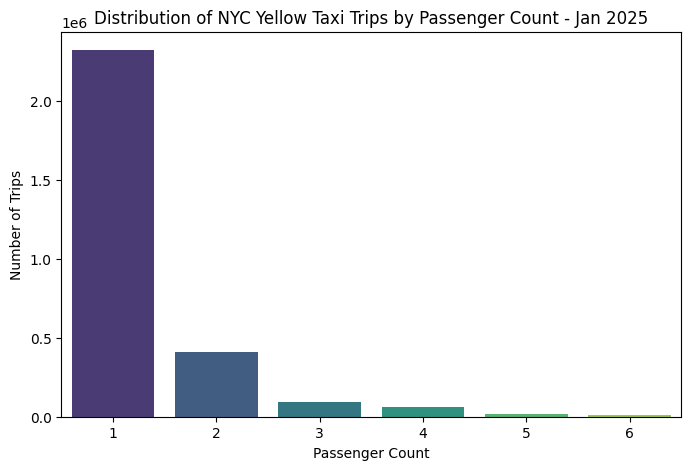

In [21]:
# Visualize passenger distribution
taskC = (
    trip_sizes.join(passenger_stats, on="passenger_count", how="inner")
              .orderBy("passenger_count")
)

taskC_pd = taskC.toPandas()
plt.figure(figsize=(8,5))
sns.barplot(data=taskC_pd, x="passenger_count", y="trip_count", palette="viridis")
plt.title("Distribution of NYC Yellow Taxi Trips by Passenger Count - Jan 2025")
plt.xlabel("Passenger Count")
plt.ylabel("Number of Trips")
plt.show()

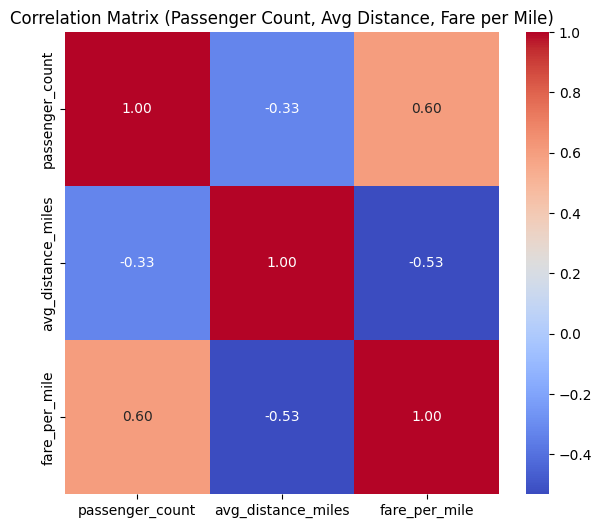

In [22]:
corr_mat = taskC_pd[["passenger_count", "avg_distance_miles", "fare_per_mile"]].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix (Passenger Count, Avg Distance, Fare per Mile)")
plt.show()

`Insights:`
1. Passenger Count vs. Avg Distance (Correlation: -0.33)
    * This is a weak negative correlation. As the number of passengers in a trip increases, the average trip distance tends to slightly decrease.
2. Passenger Count vs. Fare per Mile (Correlation: 0.60)
    * This is a moderate positive correlation. As the number of passengers in a trip increases, the fare charged per mile also tends to increase.

# Task D: Temporal Analysis

In [23]:
# Extract day-of-week and hour-of-day from pickup time.
df_D = (
    df
    .withColumn("pickup_hour", hour(col("pickup_datetime")))
    .withColumn("pickup_dow", dayofweek(col("pickup_datetime")))
    .withColumn("pickup_dow_label", date_format(col("pickup_datetime"), "E"))
)

df_D.select("pickup_datetime", "pickup_dow", "pickup_dow_label", "pickup_hour").show()

+-------------------+----------+----------------+-----------+
|    pickup_datetime|pickup_dow|pickup_dow_label|pickup_hour|
+-------------------+----------+----------------+-----------+
|2025-01-01 00:18:38|         4|             Wed|          0|
|2025-01-01 00:32:40|         4|             Wed|          0|
|2025-01-01 00:44:04|         4|             Wed|          0|
|2025-01-01 00:14:27|         4|             Wed|          0|
|2025-01-01 00:21:34|         4|             Wed|          0|
|2025-01-01 00:48:24|         4|             Wed|          0|
|2025-01-01 00:14:47|         4|             Wed|          0|
|2025-01-01 00:39:27|         4|             Wed|          0|
|2025-01-01 00:53:43|         4|             Wed|          0|
|2025-01-01 00:00:02|         4|             Wed|          0|
|2025-01-01 00:20:28|         4|             Wed|          0|
|2025-01-01 00:33:58|         4|             Wed|          0|
|2025-01-01 00:42:40|         4|             Wed|          0|
|2025-01

In [24]:
# Trip counts by day and by hour - identify peak hours
trips_by_dow = (
    df_D.groupBy("pickup_dow", "pickup_dow_label")
        .agg(count("*").alias("trip_count"))
        .orderBy("pickup_dow")   # keeps Sun→Mon→…→Sat in correct order
)
print("Trip counts by Day of Week:")
trips_by_dow.orderBy("trip_count", ascending=False).show()

Trip counts by Day of Week:
+----------+----------------+----------+
|pickup_dow|pickup_dow_label|trip_count|
+----------+----------------+----------+
|         5|             Thu|    614230|
|         6|             Fri|    586863|
|         4|             Wed|    577375|
|         7|             Sat|    476399|
|         3|             Tue|    453993|
|         1|             Sun|    402594|
|         2|             Mon|    363772|
+----------+----------------+----------+



In [25]:
trips_by_hour = (
    df_D.groupBy("pickup_hour")
        .agg(count("*").alias("trip_count"))
        .orderBy("pickup_hour")
)
print("Trip counts by Hour of Day:")
trips_by_hour.show(24)

Trip counts by Hour of Day:
+-----------+----------+
|pickup_hour|trip_count|
+-----------+----------+
|          0|     93417|
|          1|     64484|
|          2|     43929|
|          3|     28492|
|          4|     20033|
|          5|     22551|
|          6|     50026|
|          7|    102581|
|          8|    141305|
|          9|    142877|
|         10|    148316|
|         11|    160076|
|         12|    175432|
|         13|    186144|
|         14|    202289|
|         15|    213694|
|         16|    217051|
|         17|    253518|
|         18|    267951|
|         19|    221055|
|         20|    195001|
|         21|    205978|
|         22|    182214|
|         23|    136812|
+-----------+----------+



`Insights:`
* Based on the "Trip counts by Day of Week" table, the busiest days of the week are Thursdays and Fridays.
* Based on the "Trip counts by Hour of Day" table, the peak period for taxi trips is the evening rush hour.
    - The single peak hour is 18:00 (6 PM), with 267,951 trips.
    - The busiest general period is from 16:00 (4 PM) to 19:00 (7 PM), which consistently shows the highest volumes.

In [26]:
# Avg fare and avg tip per hour
fare_tip_by_hour = (
    df_D.groupBy("pickup_hour")
        .agg(
            F.round(F.avg("fare_amount"), 2).alias("avg_fare"),
            F.round(F.avg("tip_amount"), 2).alias("avg_tip")
        )
        .withColumn(
            "tip_rate_pct",
            F.round((col("avg_tip") / col("avg_fare")) * 100, 2)
        )
        .orderBy("pickup_hour")
)

fare_tip_by_hour.show(24)

+-----------+--------+-------+------------+
|pickup_hour|avg_fare|avg_tip|tip_rate_pct|
+-----------+--------+-------+------------+
|          0|   17.18|   2.66|       15.48|
|          1|   15.64|   2.36|       15.09|
|          2|   14.76|   2.21|       14.97|
|          3|    15.2|   2.25|        14.8|
|          4|   19.89|   2.67|       13.42|
|          5|   22.94|   3.02|       13.16|
|          6|   19.57|   2.53|       12.93|
|          7|   17.86|   2.56|       14.33|
|          8|   16.72|   2.55|       15.25|
|          9|   16.63|    2.9|       17.44|
|         10|   16.73|   3.05|       18.23|
|         11|   16.59|   3.03|       18.26|
|         12|   21.69|   3.04|       14.02|
|         13|   17.21|   3.14|       18.25|
|         14|   17.77|   3.21|       18.06|
|         15|   17.82|   3.22|       18.07|
|         16|   17.81|   3.44|       19.31|
|         17|   16.35|   3.08|       18.84|
|         18|   15.36|    2.8|       18.23|
|         19|   15.86|   2.96|  

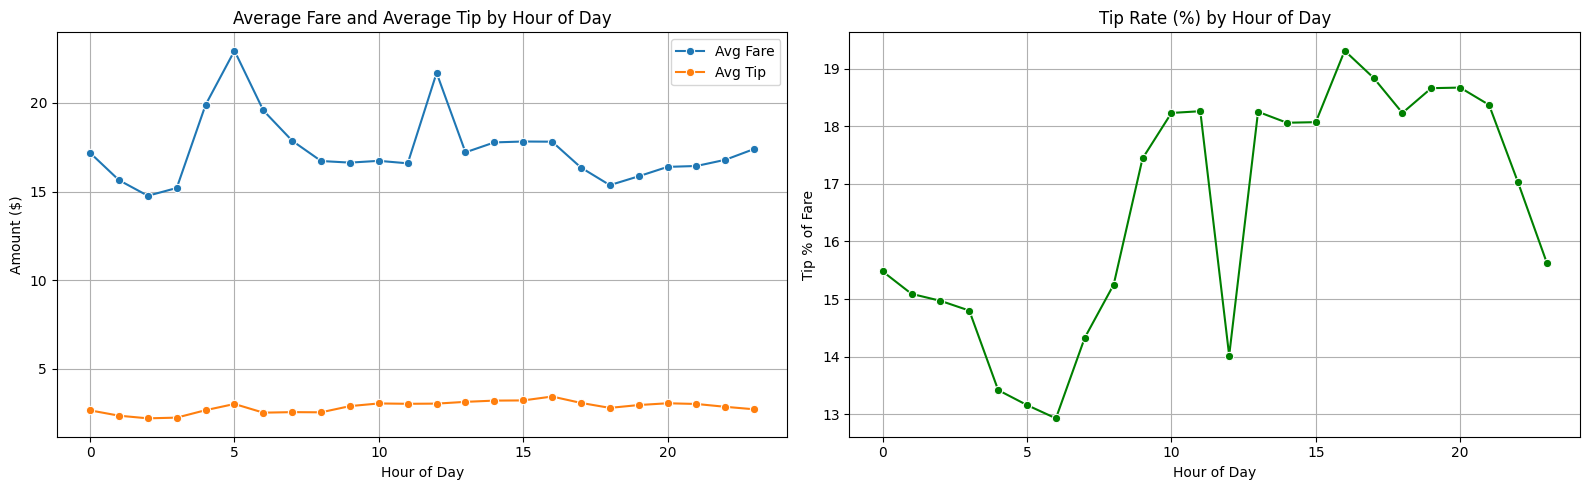

In [27]:
# Convert to pandas for visualization
fare_tip_pd = fare_tip_by_hour.toPandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# --- Average Fare and Tip by Hour ---
sns.lineplot(data=fare_tip_pd, x="pickup_hour", y="avg_fare", marker="o", label="Avg Fare", ax=axes[0])
sns.lineplot(data=fare_tip_pd, x="pickup_hour", y="avg_tip", marker="o", label="Avg Tip", ax=axes[0])
axes[0].set_title("Average Fare and Average Tip by Hour of Day")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Amount ($)")
axes[0].grid(True)
axes[0].legend()

# --- Tip Rate by Hour ---
sns.lineplot(data=fare_tip_pd, x="pickup_hour", y="tip_rate_pct", marker="o", color='green', ax=axes[1])
axes[1].set_title("Tip Rate (%) by Hour of Day")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Tip % of Fare")
axes[1].grid(True)

plt.tight_layout()
plt.show()

`Insights:`
* There is a massive spike in average fares around 5-6 AM and in the afternoon, likely due to airport trips. Outside of this spike, fares are relatively stable. Average tip amounts remain low and flat throughout the day.
* The 5-6 AM fare spike corresponds to the lowest tip percentage of the day (around 13%). The tip rate then jumps significantly after 6 AM and stays high (18-19.5%) for the entire business day and evening, except at noon (12 PM) and before dropping off after midnight.

In [28]:
spark.stop()

# Task E: Performance Comparison & Reflection

Results for small dataset (`sample_trips_small.csv`):
| **Metric**           | **Standalone (Local)** | **Cluster (2 Workers)**   | **Difference**               |
|----------------------|------------------------|---------------------------|------------------------------|
| Read Time (s)        | 2.863                  | 3.767                     | Cluster +0.9                 |
| Transform Time (s)   | 0.828                  | 1.456                     | Cluster +0.6                 |
| Aggregation Time (s) | 0.0318                 | 0.0354                    | Cluster +0.0006              |
| Total Time (s)       | 4.428                  | 6.236                     | Cluster is ~41% slower       |

Results for large dataset (`yellow_tripdata_202501.parquet`):
| **Metric**           | **Standalone (Local)** | **Cluster (2 Workers)**   | **Difference**               |
|----------------------|------------------------|---------------------------|------------------------------|
| Read Time (s)        | 2.3623                 | 3.3698                    | Cluster +1                   |
| Transform Time (s)   | 1.6127                 | 3.1341                    | Cluster +1.5                 |
| Aggregation Time (s) | 0.0326                 | 0.0334                    | Cluster +0.0008              |
| Total Time (s)       | 5.4306                 | 8.6548                    | Cluster is ~59% slower       |

`Discussion`:

**Which setup was faster?**

The standalone (local) Spark setup was faster for both datasets.
* Small dataset: Local = 4.428 s, Cluster = 6.236 s -> Cluster ~41% slower
* Large dataset: Local = 5.4306 s, Cluster = 8.6548 s -> Cluster ~59% slower

**Why was the cluster slower?**

The multi-container cluster introduces overhead that doesn’t exist in local mode:
* Worker container startup time
* Network communication between master and workers
* Scheduling and coordination overhead
* Inter-worker shuffle and serialization costs

These overheads dominate because the dataset (~3.4M rows) is too small to benefit from distributed scaling.

**Effect of startup overhead & partitioning (small vs. large dataset)**
* For the small CSV, overhead adds ~1.8 seconds over local mode.
* For the larger Parquet, overhead grows to ~3.2 seconds, because more partitions must be distributed, scheduled, and synchronized.

**Final takeaway**
For the datasets in this assignment, the workloads are too small, so local mode runs faster. More workers improve performance only when the dataset is large enough to justify distributed parallelism.

For small-to-medium datasets, adding workers increases overhead (startup, scheduling, network transfer), making the cluster slower. In this assignment, the dataset size (~3.4M rows) is not large enough to benefit from extra workers; therefore, more workers would not make the job faster—in fact, it would most likely slow it down further.